# TCC Ciências de dados 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


## Pré-processamento do texto

In [ ]:
import re
import nltk
import string
import numpy as np
from nltk.cluster.util import cosine_distance #similaridade do cosseno
from nltk.cluster.util import euclidean_distance #distância euclidiana utilizada pelo Knn (teste meu)
import networkx as nx
import pandas as pd
import random
import seaborn as sns
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Instalando a biblioteca spaCy

1.2   Importação de bibliotecas

In [ ]:
!pip install spacy==2.3.5

     |████████████████████████████████| 10.4MB 6.6MB/s 
     |████████████████████████████████| 1.1MB 43.7MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [ ]:
import spacy
spacy.__version__

'2.3.5'

In [ ]:
!python -m spacy download pt
import spacy
pln = spacy.load("pt")

     |████████████████████████████████| 19.6MB 1.2MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.3.0-cp37-none-any.whl size=19557499 sha256=eda226b32f00eb7ad3ae64abd65bc25c09ebb663c805e28a6e3c887410e15701
  Stored in directory: /tmp/pip-ephem-wheel-cache-ri1bj2td/wheels/f6/43/f6/949b5e2b48df37aa3ed81fc3f4af4154afa276518cc004b990
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [ ]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop_words_spacy = STOP_WORDS

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('rslp') #stemização
nltk.download('stopwords')
stop_words_nltk = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words = set(stop_words_nltk + list(stop_words_spacy))

In [ ]:
pontuacoes = string.punctuation
pontuacoes

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

# Avaliação na base de teste sumarizada com DCNN

## Função para calcular a similaridade entre sentenças

- Link: https://en.wikipedia.org/wiki/Cosine_similarity
- Cálculos passo a passo: https://janav.wordpress.com/2013/10/27/tf-idf-and-cosine-similarity/
- Algoritmo Page Rank: https://www.youtube.com/watch?v=YfDNI1jp5sM e https://www.youtube.com/watch?v=YplmCue8XJU

In [ ]:
def preprocessamento_cosseno(texto):
  '''
  Recebe um texto/documento.
  cria uma lista com as palavras do texto e exclui as stop_words e as pontuações.
  Retorna uma string com todas as palavras do texto após as exclusões.
  '''
  
  texto_formatado = texto.lower()
  tokens = []
  for token in nltk.word_tokenize(texto_formatado):
    tokens.append(token)

  tokens = [palavra for palavra in tokens if palavra not in stop_words and palavra not in string.punctuation]
  texto_formatado = ' '.join([str(elemento) for elemento in tokens if not elemento.isdigit()])
  return texto_formatado

In [ ]:
def calcula_similaridade_sentencas(sentenca1, sentenca2):
  '''
  A função recebe duas sentenças/frases e cria uma lista sem repetição das palavras das duas sentenças.
  Em seguida, cria um vetor para cada uma das sentenças com o número de posições igual ao número de palavras.
  Depois, para cada sentença, conta a quantidade de vezes que cada palavra ocorre e registra a quantidade na posição correspondente do vetor.
  Ao final, calcula a similaridade entre os vetores (sentenças) utilizando a função cosine_distance da biblioteca nltk.
  Quanto menor a distância, maior a similaridade. A distância varia entre 0 e 1.
  A função retorna a nota de similaridade (por isso 1 menos cosine_distance).
  '''

  palavras1 = [palavra for palavra in nltk.word_tokenize(sentenca1)]
  palavras2 = [palavra for palavra in nltk.word_tokenize(sentenca2)]

  todas_palavras = list(set(palavras1 + palavras2))

  vetor1 = [0] * len(todas_palavras)
  vetor2 = [0] * len(todas_palavras)

  for palavra in palavras1:
    vetor1[todas_palavras.index(palavra)] += 1
  for palavra in palavras2:
    vetor2[todas_palavras.index(palavra)] += 1

  return 1 - cosine_distance(vetor1, vetor2)

In [ ]:
def calcula_matriz_similaridade(sentencas):
  '''
  Recebe uma lista com todas as sentenças do documento.
  Em seguida, cria uma matriz de duas dimensões com o número de ocorrências igual ao número de sentenças.
  Ao final, calcula a similaridade entre cada sentença e as demais por meio da função 
  calcula_similaridade_sentencas e guarda a nota na matriz.
  Retorna a matriz de similaridade.
  '''
  matriz_similaridade = np.zeros((len(sentencas), len(sentencas)))

  for i in range(len(sentencas)):
    for j in range(len(sentencas)):
      if i == j:
        continue
      resultado_similaridade = calcula_similaridade_sentencas(sentencas[i], sentencas[j])

      if  not math.isnan(resultado_similaridade):
        matriz_similaridade[i][j] = resultado_similaridade    
      else: #atribuir valor 0 aos resultados de similaridade Nan. Zero significa que as sentenças não tem similaridade.
        matriz_similaridade[i][j] = 0
        
  return matriz_similaridade

In [ ]:
def sumarizar_similaridade_cosseno(texto):
  '''
  Recebe um texto/documento.
  Por meio da função preprocessamento_cosseno, exclui stop_words e pontuações.
  Por meio da função calcula_matriz_similaridade, obtem a matriz com a similaridade entre as sentenças do documento.
  Transforma a matriz em um grafo. O grafo mostra as ligações entre as sentenças. 
  Por meio do algoritmo PageRank será calculada a classificação das frases (transformadas em grafos), ou seja, dos nós com base na estrutura dos 
  links de entrada (a ligação entre as sentenças). 
  Esse algoritmo foi originalmente projetado como um algoritmo para classificar páginas da web. É o algoritmo do google que transformou o seu motor de busca em um dos
  mais populares do mundo.
  Calcula a quantidade de sentenças que representa 40% do documento e obtém as melhores sentenças com base nessa quantidade.
  Retorna as melhores sentenças.
  '''
  sentencas_originais = [sentenca for sentenca in nltk.sent_tokenize(texto) if re.search('[a-zA-Z]+', sentenca)] #excluir sentenças sem palavras/letras

  sentencas_formatadas = [preprocessamento_cosseno(sentenca_original) for sentenca_original in sentencas_originais]

  matriz_similaridade = calcula_matriz_similaridade(sentencas_formatadas)
  
  grafo_similaridade = nx.from_numpy_array(matriz_similaridade)

  notas = nx.pagerank(grafo_similaridade, max_iter=20000)

  notas_ordenadas = sorted(((notas[i], nota) for i, nota in enumerate(sentencas_originais)), reverse=True)

  quantidade_sentencas = int(0.4 * len(sentencas_originais))
  if quantidade_sentencas < 3:
    quantidade_sentencas = 3
    if quantidade_sentencas > len(sentencas_originais):
      quantidade_sentencas = len(sentencas_originais)

  melhores_sentencas = []
  for i in range(quantidade_sentencas):
    melhores_sentencas.append(notas_ordenadas[i][1])
  melhores_sentencas = str(melhores_sentencas).replace("',", '').replace("'", '').replace('[', '').replace(']', '')

  return melhores_sentencas

In [ ]:
#Carregar dataframe X_teste diretamente do drive.
url = '/content/drive/MyDrive/X_teste_1781.csv' 
X_teste = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True) 

In [ ]:
#Executa rotina de sumarização para todos os votos do dataframe X_teste
X_teste['voto'] = X_teste['voto'].apply(sumarizar_similaridade_cosseno)
X_teste_sumarizado = X_teste.copy()

In [ ]:
X_teste_sumarizado.head()

,voto
0,conforme estabelecido no despacho de admissibi...
1,o acórdão decorrido debruçou-se sobre a matéri...
2,a fiscalização glosou as áreas declaradas de p...
3,"entendo que o pedido da recorrente, relativo a..."
4,"na hipótese dos autos, a querela se resume em ..."


In [ ]:
#Definir qual é o modelo a ser treinado. Se lematizado, stemizado ou palavras originais.
#A variável tipo_modelo será definida aqui e será utilizada para fazer o direcionamento ao carregar o X_treinamento preprocessado, 
#no preprocessamento de X_teste, ao salvar o modelo, ao carregar o modelo treinado e ao exibir os resultados.
tipo_modelo = 'lema' #escolher 'lema', 'stemer' ou 'original'

In [ ]:
#rodar preprocessamento selecionando entre lema, stemer ou original. Usar o mesmo utilizado para treinar o modelo.
X_teste_sumarizado['voto'] = X_teste_sumarizado['voto'].apply(preprocessamento, args=(tipo_modelo,))
X_teste_sumarizado_preprocessado = X_teste_sumarizado.copy()

In [ ]:
X_teste_sumarizado_preprocessado.head()

,voto
0,conformar estabelecer despachar admissibilidad...
1,acórdão decorrer debruçou-se matéria conclusão...
2,fiscalização glosar área declarar preservação ...
3,entender pedir recorrente relativo per dcomp t...
4,hipótese auto querelar resumir definir documen...


In [ ]:
#transformar X_teste em numpy.ndarray
dados_teste_preprocessados = X_teste_sumarizado_preprocessado.iloc[:, 0].values

## Criando os corpus de treinamento com palavras originais

3. Escolher o tipo de modelo

In [ ]:
#Definir qual é o modelo a ser treinado. Se lematizado, stemizado ou palavras originais.
#A variável tipo_modelo será definida aqui e será utilizada para fazer o direcionamento ao carregar o X_treinamento preprocessado, 
#no preprocessamento de X_teste, ao salvar o modelo, ao carregar o modelo treinado e ao exibir os resultados.
tipo_modelo = 'lema' #escolher 'lema', 'stemer' ou 'original'

4. Ler arquivos do Drive gravados pelo notebook TCC_p01_preparar_X_treinamento_e_y_teste

In [ ]:
#Recuperando os arquivos de treinamento após preprocessamento salvos no drive. Verificar qual X irá treinar, se lema, stemer ou origianl.
if tipo_modelo == 'lema':
  url = '/content/drive/MyDrive/X_treinamento_lema.csv'
elif tipo_modelo == 'stemer':
  url = '/content/drive/MyDrive/X_treinamento_stemer.csv'
else:
  url = '/content/drive/MyDrive/X_treinamento_original.csv'
  
X_treinamento = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True, quotechar='"', error_bad_lines=False)

In [ ]:
#transforma X_treinamento e y_treinamento em numpy.ndarray
X_treinamento_preprocessado = X_treinamento.iloc[:, 0].values

#Preparar os dados de teste

In [ ]:
def preprocessamento(texto, tipo):
  """
  Faz uma limpeza do texto recebido excluíndo pontuações, stop words, números em moedas, leis, etc, letras soltas, palavras com duas letras, 
  hífens iniciais, r$, espaços duplos e símbolos.  
  O objetivo é deixar apenas palavras que serão a base para as classificações.

  :parâmetro texto: recebe o texto integral de um voto.
  :parâmetro tipo: escolher entre 'lema', 'stemer' e 'original'. Lema faz lematização das palavras, stemer faz a stemização e original mantém as palavras sem alterações.
  :retorno str_lista: string com a lista das palavras do voto após a limpeza dos dados.  

  """

  texto = texto.lower()
  texto = re.sub('([¹²³£¢¬§ªº°]{1})', ' ', texto) #excluir o símbolos listados
  texto = re.sub('([!"#%&\'\(\)\*\+,\./:;<=>\?@\[\]\^_`\{\|\}~]{1})', ' ', texto) #excluir as pontuações, exceto o hífen
  texto = re.sub('([0-9]*)[\.]*([0-9]+,[0-9]+)', ' ', texto)  #excluir valores com decimais após vírgulas 10.000,00 30,00
  texto = re.sub('([0-9]+)[.]+([0-9]+)\/([0-9]+)', ' ', texto) #excluir valores tipo leis 9.420/99
  texto = re.sub('([0-9]+)\/([0-9]+)', ' ', texto) #excluir valores tipo leis 70/99
  texto = re.sub('([0-9]+)', ' ', texto) #excluir números
  texto = re.sub('( [a-z]{1} )', ' ', texto) #excluir letras soltas
  texto = re.sub('( [a-z]{2} )', ' ', texto) #excluir palavras com 2 letras
  texto = re.sub(' -([a-z]*)', r'\1', texto) #excluir hífens iniciais
  texto = texto.replace('r$', ' ') #excluir r$
  texto = re.sub('( [ ]*)', ' ', texto) #excluir espaços duplos

  documento = pln(texto)
  lista = [token.text for token in documento if token.text not in stop_words and token.text not in string.punctuation]
  str_lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
  documento = pln(str_lista)
  
  lista = []
  if tipo == 'lema': # Lematização
    for token in documento:
      lista.append(token.lemma_)  
  elif tipo == 'stemer':
    for token in documento:
      stemmer = nltk.stem.RSLPStemmer()
      lista.append(stemmer.stem(token.text))
  else: #'original' ou qualquer outro valor
    for token in documento:
      lista.append(token.text)    

  str_lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
  
  return str_lista

### Limpeza

In [ ]:
num_words = 2**16
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.4.1'

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer as TokenizerTS
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Tokenize our training data
tokenizerTS = TokenizerTS(num_words=num_words, oov_token=oov_token)
tokenizerTS.fit_on_texts(X_treinamento_preprocessado)

# Get our training data word index
vocab_size = len(tokenizerTS.word_index) + 1

In [ ]:
vocab_size

31617

In [ ]:
#Informa do valor de max_len utilizado para o padding. Os valores foram obtidos do notebook TCC_p03a_Classificação_DCNN_lema quando rodou-se o modelo.
if tipo_modelo == 'lema':
  max_len = 7622
elif tipo_modelo == 'stemer':
  max_len = 7610
else:
  max_len = 7622

In [ ]:
# Encode training data sentences into sequences
X_teste_vetor_numerico = tokenizerTS.texts_to_sequences(dados_teste_preprocessados)

# Pad the training sequences
X_teste_vetor_numerico = pad_sequences(X_teste_vetor_numerico, padding=pad_type, truncating=trunc_type, maxlen=max_len)

In [ ]:
#Carrega o y_teste do Drive
url = '/content/drive/MyDrive/y_teste_1781.csv' 
y_teste = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True)
rotulos_teste = y_teste.iloc[:, 0].values

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


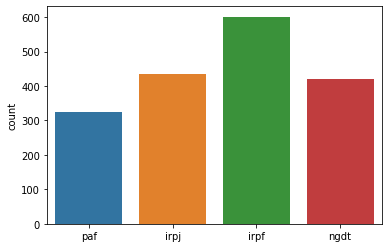

In [ ]:
sns.countplot(rotulos_teste);

In [ ]:
#rotulos para o gráfico matriz de confusão
rotulos_plt_cm = ['irpj', 'irpf', 'ngdt', 'paf']

In [ ]:
rotulos_teste[rotulos_teste == 'irpj'] = 0
rotulos_teste[rotulos_teste == 'irpf'] = 1
rotulos_teste[rotulos_teste == 'ngdt'] = 2
rotulos_teste[rotulos_teste == 'paf'] = 3
rotulos_teste = rotulos_teste.astype(np.int32)
rotulos_teste

array([3, 0, 1, ..., 3, 3, 0], dtype=int32)

## Avaliação do sumarizador pela similaridade do cosseno com o modelo da rede neural convolucional

In [ ]:
#Carregando modelo treinado que foi salvo no drive.
Dcnn = tf.keras.models.load_model('/content/drive/MyDrive/modelo_Dcnn_lema')

In [ ]:
#Verificando a arquitetura do modelo
Dcnn.summary()

Model: "dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  6323400   
_________________________________________________________________
conv1d_3 (Conv1D)            multiple                  40100     
_________________________________________________________________
conv1d_4 (Conv1D)            multiple                  60100     
_________________________________________________________________
conv1d_5 (Conv1D)            multiple                  80100     
_________________________________________________________________
global_max_pooling1d_1 (Glob multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  77056     
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0      

In [ ]:
y_pred_test = Dcnn.predict(X_teste_vetor_numerico)
lista_predict = y_pred_test.argmax(axis=1) 

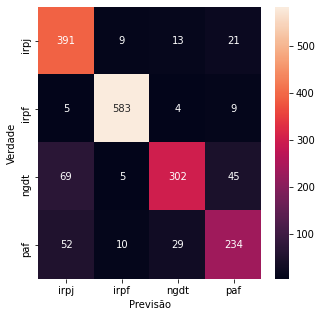

In [ ]:
conf_mat_nb = confusion_matrix(rotulos_teste, lista_predict)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_nb, annot=True, fmt='d',
            xticklabels=rotulos_plt_cm, yticklabels=rotulos_plt_cm)
plt.ylabel('Verdade')
plt.xlabel('Previsão')
plt.show()

In [ ]:
accuracy_score(rotulos_teste, lista_predict)

0.8478382930937676